# Generate the figures for the manuscript

In [1]:
import platform
import os
import glob
import pandas
import dask
from dask.distributed import Client, LocalCluster
import dask_image.imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib_scalebar.scalebar import ScaleBar
# from matplotlib.gridspec import GridSpec
from matplotlib.markers import MarkerStyle
from string import ascii_uppercase
import seaborn
import numpy
from tqdm.auto import tqdm, trange
import imageio
import skimage

In [2]:
# Import our own parsing functions which we've added as submodule
from BrukerSkyScanLogfileRuminator.parsing_functions import *

In [3]:
# Set dask temporary folder
# Do this before creating a client: https://stackoverflow.com/a/62804525/323100
import tempfile
if 'Linux' in platform.system():
    tmp = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
elif 'Darwin' in platform.system():
    tmp = tempfile.gettempdir()
else:
    if 'anaklin' in platform.node():
        tmp = os.path.join('F:\\')
    else:
        tmp = os.path.join('D:\\')
dask.config.set({'temporary_directory': os.path.join(tmp, 'tmp')})
print('Dask temporary files go to %s' % dask.config.get('temporary_directory'))

Dask temporary files go to /media/habi/Fast_SSD/tmp


In [4]:
# Start cluster and client now, after setting tempdir
try:
    cluster = LocalCluster()
except PermissionError:
    print('Mount the Fast_SSD, otherwise we cannot use it for saving the temporary files!')
    print('Then rerun this cell.')
client = Client(cluster)

In [5]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [6]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [7]:
# Set seaborn context
# context: one of {paper, notebook, talk, poster}
seaborn.set_context('paper')

In [8]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.dpi'] = 200

In [9]:
# Set default figure size, see https://stackoverflow.com/a/41717533
# Good to do after we're setting something strange below.
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [10]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [11]:
# Different locations if running either on Linux or Windows
FastSSD = True
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', 'research_storage_djonov')
elif 'Darwin' in platform.system():
    # First mount smb://resstore.unibe.ch/ana_rs_djonov/data in the Finder
    FastSSD = False
    BasePath = os.path.join('/Volumes/data/')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('V:\\')
        else:
            BasePath = os.path.join('V:\\')
Root = os.path.join(BasePath, 'Aaldijk', 'PelvicFloor')
print('We are loading all the data from %s' % Root)

We are loading all the data from /media/habi/Fast_SSD/Aaldijk/PelvicFloor


In [12]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [13]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving all the output to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving all the output to /home/habi/P/Documents/Dea-Beckenboden/Output/25a48fb


In [14]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [15]:
# Get *all* log files, unsorted but faster than with glob
print('Searching for all log files in %s' % Root)
Data['LogFile'] = [os.path.join(root, name)
                   for root, dirs, files in os.walk(Root)
                   for name in files
                   if name.endswith((".log"))]

Searching for all log files in /media/habi/Fast_SSD/Aaldijk/PelvicFloor


In [16]:
# Drop all the scans that are not of Foetus02
for c, row in Data.iterrows():
    if 'Foetus02' not in row.LogFile:
        Data.drop([c], inplace=True)
Data.reset_index(drop=True)

LogFile
0   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
1   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
2   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
3   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
4   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
5   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
6   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
7   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
8   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
9   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
10  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
11  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
12  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
13  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
14  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
15  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
16  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
17  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
18  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
19  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
20  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
21  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
22  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
23  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
24  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
25  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
26  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
27  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
28  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
29  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
30  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
31  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
32  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
33  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
34  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
35  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
36  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
37  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
38  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
39  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...
40  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...

In [17]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [18]:
# Get rid of all logfiles that we don't want and need
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:  # drop all non-rec folders
        Data.drop([c], inplace=True)
    elif 'SubScan' in row.Folder:  # drop all partial reconstructions which might be there from synchronization
        Data.drop([c], inplace=True)        
    elif 'rectmp.log' in row.LogFile:  # drop all temporary logfiles
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [19]:
# Generate us some meaningful colums
Data['Sample'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['SampleName'] = [sn.split('_')[0] for sn in Data['Sample']]
Data['Scan'] = ['_'.join(l[len(Root)+1:].split(os.sep)[1:-1]) for l in Data['LogFile']]

In [20]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [21]:
Data

LogFile  \
0   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
1   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
2   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
3   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
4   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
5   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
6   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
7   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
8   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
9   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
10  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
11  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
12  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
13  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
14  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
15  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
16  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   

                                               Folder  \
0   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
1   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
2   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
3   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
4   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
5   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
6   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
7   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
8   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
9   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
10  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
11  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
12  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
13  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
14  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
15  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
16  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   

                       Sample SampleName            Scan  \
0   Foetus02_Lugol_15pct_060d   Foetus02             rec   
1   Foetus02_Lugol_10pct_014d   Foetus02             rec   
2                    Foetus02   Foetus02             rec   
3   Foetus02_Lugol_15pct_044d   Foetus02             rec   
4   Foetus02_Lugol_15pct_088d   Foetus02             rec   
5   Foetus02_Lugol_15pct_098d   Foetus02             rec   
6   Foetus02_Lugol_15pct_152d   Foetus02             rec   
7   Foetus02_Lugol_15pct_152d   Foetus02  rec_11um_DICOM   
8   Foetus02_Lugol_15pct_152d   Foetus02        rec_11um   
9   Foetus02_Lugol_05pct_007d   Foetus02             rec   
10  Foetus02_Lugol_15pct_053d   Foetus02             rec   
11  Foetus02_Lugol_15pct_077d   Foetus02             rec   
12  Foetus02_Lugol_15pct_108d   Foetus02             rec   
13  Foetus02_Lugol_15pct_108d   Foetus02        rec_11um   
14  Foetus02_Lugol_15pct_141d   Foetus02             rec   
15  Foetus02_Lugol_10pct_025d   Foetus02             rec   
16  Foetus02_Lugol_15pct_070d   Foetus02             rec   

                                      Reconstructions  \
0   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
1   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
2   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
3   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
4   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
5   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
6   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
7                                                  []   
8   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
9   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
10  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
11  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
12  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
13  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
14  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   

In [22]:
Data.SampleName.unique()

array(['Foetus02'], dtype=object)

In [23]:
# Drop samples which have either not been reconstructed yet or of which we deleted the reconstructions with
# `find . -name "*rec*.png" -type f -mtime +333 -delete`
# Based on https://stackoverflow.com/a/13851602
# for c,row in Data.iterrows():
#     if not row['Number of reconstructions']:
#         print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True)
print('We have %s folders with reconstructions' % (len(Data)))

We have 16 folders with reconstructions


In [24]:
Data

LogFile  \
0   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
1   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
2   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
3   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
4   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
5   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
6   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
8   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
9   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
10  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
11  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
12  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
13  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
14  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
15  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
16  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   

                                               Folder  \
0   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
1   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
2   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
3   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
4   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
5   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
6   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
8   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
9   /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
10  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
11  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
12  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
13  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
14  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
15  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   
16  /media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foetu...   

                       Sample SampleName      Scan  \
0   Foetus02_Lugol_15pct_060d   Foetus02       rec   
1   Foetus02_Lugol_10pct_014d   Foetus02       rec   
2                    Foetus02   Foetus02       rec   
3   Foetus02_Lugol_15pct_044d   Foetus02       rec   
4   Foetus02_Lugol_15pct_088d   Foetus02       rec   
5   Foetus02_Lugol_15pct_098d   Foetus02       rec   
6   Foetus02_Lugol_15pct_152d   Foetus02       rec   
8   Foetus02_Lugol_15pct_152d   Foetus02  rec_11um   
9   Foetus02_Lugol_05pct_007d   Foetus02       rec   
10  Foetus02_Lugol_15pct_053d   Foetus02       rec   
11  Foetus02_Lugol_15pct_077d   Foetus02       rec   
12  Foetus02_Lugol_15pct_108d   Foetus02       rec   
13  Foetus02_Lugol_15pct_108d   Foetus02  rec_11um   
14  Foetus02_Lugol_15pct_141d   Foetus02       rec   
15  Foetus02_Lugol_10pct_025d   Foetus02       rec   
16  Foetus02_Lugol_15pct_070d   Foetus02       rec   

                                      Reconstructions  \
0   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
1   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
2   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
3   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
4   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
5   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
6   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
8   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
9   [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
10  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
11  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
12  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
13  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
14  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
15  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   
16  [/media/habi/Fast_SSD/Aaldijk/PelvicFloor/Foet...   

    Number of reconstructions  
0                        1941  
1                        1941  
2                        1941  
3                        1941  
4                        1941  
5                        

In [25]:
# Get scanning parameters to doublecheck from logfiles
Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
Data['Voltage'] = [voltage(log) for log in Data['LogFile']]
Data['Current'] = [current(log) for log in Data['LogFile']]
Data['Voxelsize'] = [pixelsize(log, rounded=True) for log in Data['LogFile']]
Data['CameraWindow'] = [projection_size(log) for log in Data['LogFile']]
Data['Exposuretime'] = [exposuretime(log) for log in Data['LogFile']]
Data['Averaging'] = [averaging(log) for log in Data['LogFile']]
Data['Stacks'] = [stacks(log) for log in Data['LogFile']]
Data['RotationStep'] = [rotationstep(log) for log in Data['LogFile']]
Data['Scan date'] = [scandate(log) for log in Data['LogFile']]
Data['Scan time'] = [duration(log) for log in Data['LogFile']]

/tmp/ipykernel_1216044/1878261295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Scanner'] = [scanner(log) for log in Data['LogFile']]
/tmp/ipykernel_1216044/1878261295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Voltage'] = [voltage(log) for log in Data['LogFile']]
/tmp/ipykernel_1216044/1878261295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [26]:
# Sort our dataframe by scan date
Data.sort_values(by='Scan date', inplace=True, ignore_index=True)

/tmp/ipykernel_1216044/3596310078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.sort_values(by='Scan date', inplace=True, ignore_index=True)


In [27]:
# Get reconstruction parameters to doublecheck from logfiles
Data['Grayvalue'] = [reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [ringremoval(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [beamhardening(log) for log in Data['LogFile']]
Data['DefectPixelMasking'] = [defectpixelmasking(log) for log in Data['LogFile']]
Data['ROI'] = [region_of_interest(log) for log in Data['LogFile']]
Data['Rot'] = [crosssection_rotation(l) for l in Data.LogFile]

/tmp/ipykernel_1216044/3641821457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Grayvalue'] = [reconstruction_grayvalue(log) for log in Data['LogFile']]
/tmp/ipykernel_1216044/3641821457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['RingartefactCorrection'] = [ringremoval(log) for log in Data['LogFile']]
/tmp/ipykernel_1216044/3641821457.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [28]:
# Calculate time 'spent' since start
Data['Time passed'] = [sd - Data['Scan date'].min() for sd in Data['Scan date']]
# Also extract days, rounded
Data['Days passed'] = [t.round('d') for t in Data['Time passed']]

/tmp/ipykernel_1216044/1023812968.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Time passed'] = [sd - Data['Scan date'].min() for sd in Data['Scan date']]
/tmp/ipykernel_1216044/1023812968.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Days passed'] = [t.round('d') for t in Data['Time passed']]


In [29]:
# Load all reconstructions into ephemereal DASK arrays
#Reconstructions = [None] * len(Data)
#for c, row in tqdm(Data.iterrows(),
#                   desc='Load reconstructions',
#                   total=len(Data)):
#    Reconstructions[c] = dask_image.imread.imread(os.path.join(row['Folder'],
#                                                               '*rec*.png'))

In [30]:
# Convert all reconstructions into zarrays on disk, optimized for fast reading
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [((os.path.join(os.path.dirname(f), s)) + '.' + rf + '.zarr') for f, s, rf in zip(Data['Folder'],
                                                                                                          Data['Sample'],
                                                                                                          Data['Scan'])]
for c, row in tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%2s/%2s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root) + 1:]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], '*rec*.png'))[:,:,:,0]
        # Save out to automatically rechunked and un-compressed zarr files.
        # This takes a *long* time, but subsequent operations are much quicker afterwards
        Reconstructions.rechunk('auto').to_zarr(row['OutputNameRec'],
                                                overwrite=True)

/tmp/ipykernel_1216044/2241717178.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['OutputNameRec'] = [((os.path.join(os.path.dirname(f), s)) + '.' + rf + '.zarr') for f, s, rf in zip(Data['Folder'],


Converting reconstructions to .zarr:   0%|          | 0/16 [00:00<?, ?it/s]

In [31]:
# Load the reconstructions from the zarrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [32]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

/tmp/ipykernel_1216044/2193068561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Size'] = [rec.shape for rec in Reconstructions]


In [35]:
subsample = 1

In [37]:
# Calculate the histograms of *all* the reconstructions
# Caveat: dask.da.histogram returns histogram AND bins, making each histogram a 'nested' list of [h, b]
Data['Histogram'] = [dask.array.histogram(dask.array.array(rec[::subsample,::subsample,::subsample]),
                                          bins=2**8,
                                          range=[0, 2**8]) for rec in Reconstructions]
# Actually compute the data and put only h into the dataframe, so we can use it below.
# Discard the bins
Data['Histogram'] = [h.compute() for h, b in Data['Histogram']]

/tmp/ipykernel_1216044/3789346290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Histogram'] = [dask.array.histogram(dask.array.array(rec[::subsample,::subsample,::subsample]),
/tmp/ipykernel_1216044/3789346290.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Histogram'] = [h.compute() for h, b in Data['Histogram']]


In [38]:
# Calculate the Otsu threshold of *all* the reconstructions, subsampled for speed reasons
Data['Threshold_Multi_Otsu'] = [skimage.filters.threshold_multiotsu(rec[::subsample,::subsample,::subsample].compute()) for rec in Reconstructions]

/tmp/ipykernel_1216044/180780858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Threshold_Multi_Otsu'] = [skimage.filters.threshold_multiotsu(rec[::subsample,::subsample,::subsample].compute()) for rec in Reconstructions]


In [39]:
# Save only first value for the remainder of the script
Data['Threshold_Otsu'] = [t[0] for t in Data['Threshold_Multi_Otsu']]

/tmp/ipykernel_1216044/1094780250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Threshold_Otsu'] = [t[0] for t in Data['Threshold_Multi_Otsu']]


In [40]:
Data.Threshold_Otsu.mean()

np.float64(21.375)

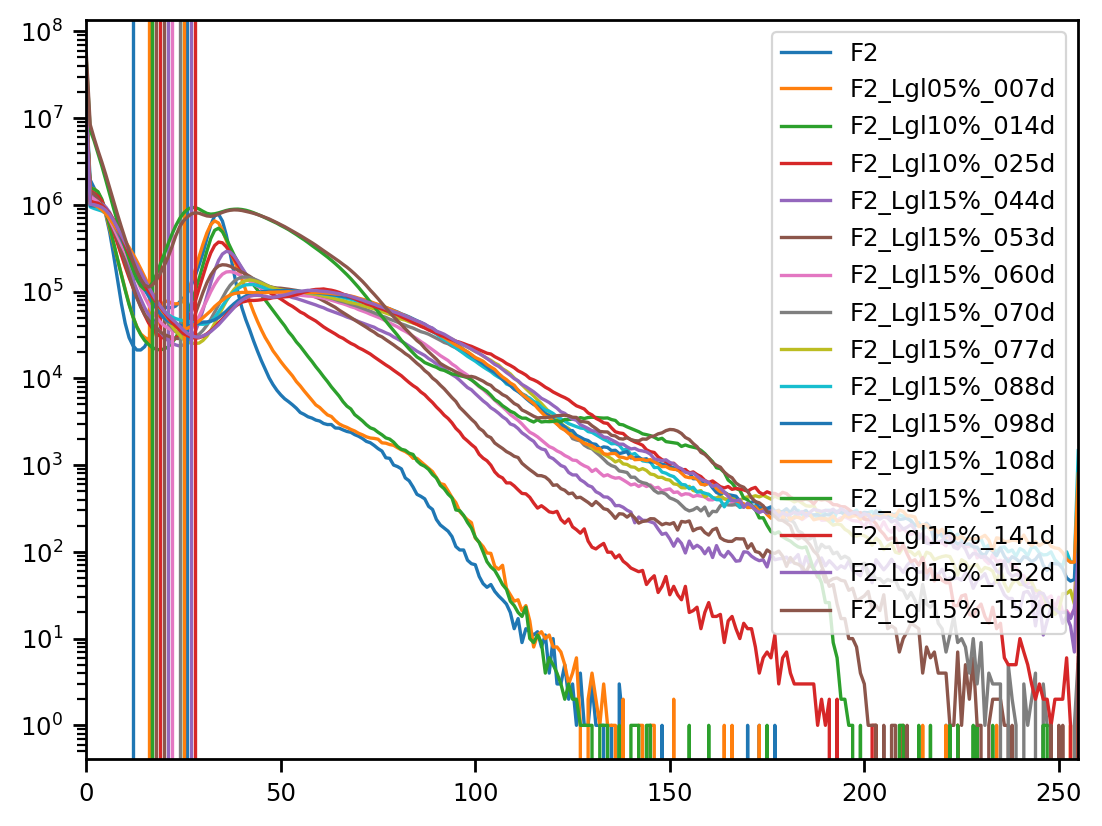

In [41]:
for c, row in sorted(Data.iterrows()):
    # Show *all* the grey value histograms    
    plt.semilogy(row.Histogram,
                 label='%s' % row.Sample.replace('Foetus02', 'F2').replace('_Lugol_','_Lgl').replace('pct','%'),
                 color=seaborn.color_palette(n_colors=len(Data))[c])
    # Show *all* the Thresholds, too    
    plt.axvline(row.Threshold_Otsu,
                color=seaborn.color_palette(n_colors=len(Data))[c])
plt.xlim([0, 255])
plt.legend()
plt.show()

In [42]:
# Mask all the background
# This is *extremely* simple segmentation, but gives us a better estimate on the grey value *in* the sample by discarding the background
Reconstructions_masked = [dask.array.ma.masked_less(rec, threshold) for rec, threshold in zip(Reconstructions,
                                                                                              Data['Threshold_Otsu'])]

In [151]:
# for c, row in Data.iterrows():
#     # plt.subplot(121)
#     plt.imshow(Reconstructions[c][row.Size[0]//2])
#     # plt.subplot(122)
#     plt.imshow(Reconstructions_masked[c][row.Size[0]//2], cmap='viridis')
#     plt.title('Middle slice of %s>%s' % (row.Sample, row.Threshold_Otsu))
#     plt.axis('off')
#     plt.gca().add_artist(ScaleBar(row.Voxelsize,'um'))
#     plt.show()

In [44]:
# Calculate mean brightness of the reconstructions
# Subsample for speed reasons, the subsample value is given above
Data['MeanBrightness'] = [rec[::subsample,::subsample,::subsample].mean().compute()
                          for rec in Reconstructions]

/tmp/ipykernel_1216044/2985986578.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['MeanBrightness'] = [rec[::subsample,::subsample,::subsample].mean().compute()


In [45]:
# Calculate mean brightness of the masked reconstructions
Data['MeanBrightness_masked'] = [rec[::subsample,::subsample,::subsample].mean().compute()
                                 for rec in Reconstructions_masked]

/tmp/ipykernel_1216044/1584482455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['MeanBrightness_masked'] = [rec[::subsample,::subsample,::subsample].mean().compute()


In [46]:
Data[['Sample', 'MeanBrightness', 'MeanBrightness_masked']]

Sample  MeanBrightness  MeanBrightness_masked
0                    Foetus02        8.038929              32.532929
1   Foetus02_Lugol_05pct_007d        8.752232              33.509520
2   Foetus02_Lugol_10pct_014d        8.761653              36.672162
3   Foetus02_Lugol_10pct_025d       10.172073              41.951357
4   Foetus02_Lugol_15pct_044d       11.863288              49.204406
5   Foetus02_Lugol_15pct_053d       11.391310              48.068266
6   Foetus02_Lugol_15pct_060d       12.587156              53.550524
7   Foetus02_Lugol_15pct_070d       13.582872              57.912127
8   Foetus02_Lugol_15pct_077d       14.125999              60.690453
9   Foetus02_Lugol_15pct_088d       14.252891              60.220270
10  Foetus02_Lugol_15pct_098d       14.014780              61.930966
11  Foetus02_Lugol_15pct_108d       14.480684              60.765202
12  Foetus02_Lugol_15pct_108d       13.028470              41.388657
13  Foetus02_Lugol_15pct_141d       14.236100              65.168148
14  Foetus02_Lugol_15pct_152d       14.260868              64.036491
15  Foetus02_Lugol_15pct_152d       12.122071              43.119789

In [47]:
# Convert the scan date to ordinal date, otherwise seaborn cannot plot them with a regplot
# https://stackoverflow.com/a/47877062
from datetime import date
Data['Scan date ordinal'] = pandas.to_datetime(Data['Scan date']).apply(lambda date: date.toordinal())
Data['Time passed ordinal'] = [t - Data['Scan date ordinal'].min() for t in Data['Scan date ordinal']]

/tmp/ipykernel_1216044/2184447526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Scan date ordinal'] = pandas.to_datetime(Data['Scan date']).apply(lambda date: date.toordinal())
/tmp/ipykernel_1216044/2184447526.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Time passed ordinal'] = [t - Data['Scan date ordinal'].min() for t in Data['Scan date ordinal']]


/tmp/ipykernel_1216044/3886508954.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=-60)


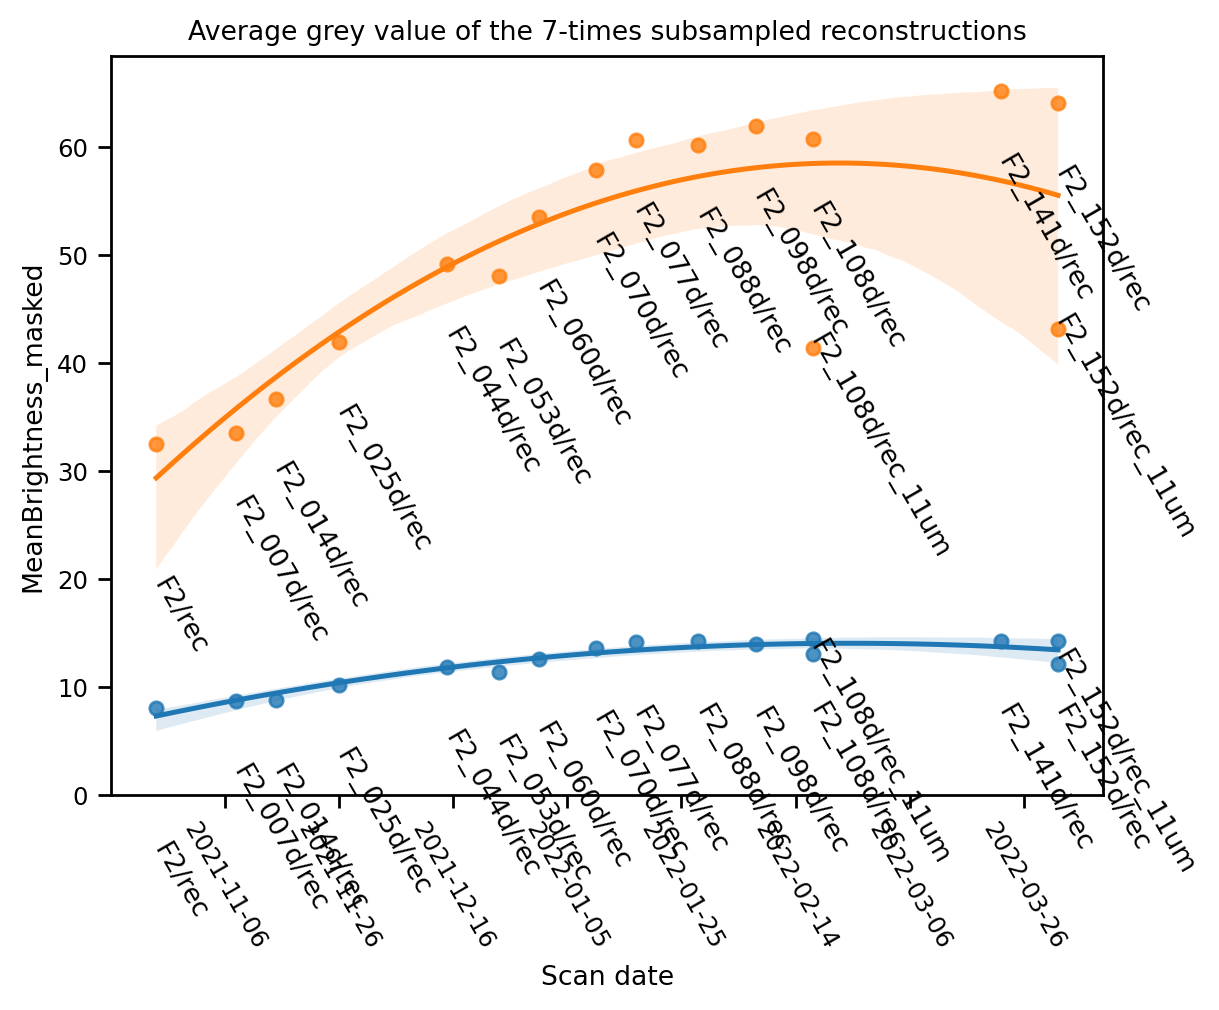

In [48]:
# Plot the mean brightness (original and masked) of the scan with their dates
seaborn.regplot(data=Data,
                x='Scan date ordinal',
                y='MeanBrightness',
                order=2)
seaborn.regplot(data=Data,
                x='Scan date ordinal',
                y='MeanBrightness_masked',
                order=2)
plt.ylim(ymin=0)
# Relabel the x-axis with the 'real', not 'ordinal' date
plt.gca().set_xlabel('Scan date')
new_labels = [date.fromordinal(int(item)) for item in plt.gca().get_xticks()]
plt.gca().set_xticklabels(new_labels, rotation=-60)
# Label text: https://matplotlib.org/stable/tutorials/text/annotations.html
for c,row in Data.iterrows():
    plt.gca().annotate('%s/%s' % (row.Sample.replace('Foetus02', 'F2').replace('_Lugol','').replace('_05pct','').replace('_10pct','').replace('_15pct',''), row.Scan),
                       xy=(row['Scan date ordinal'], row.MeanBrightness),
                       xycoords='data',
                       xytext=(-3, -75),
                       textcoords='offset points',
                       ha='left',
                       rotation=-60)
    plt.gca().annotate('%s/%s' % (row.Sample.replace('Foetus02', 'F2').replace('_Lugol','').replace('_05pct','').replace('_10pct','').replace('_15pct',''), row.Scan),
                       xy=(row['Scan date ordinal'], row.MeanBrightness_masked),
                       xycoords='data',
                       xytext=(-3, -75),
                       textcoords='offset points',
                       ha='left',
                       rotation=-60)    
plt.title('Average grey value of the %s-times subsampled reconstructions' % subsample)
plt.show()

In [49]:
Data[['Sample', 'Scan', 'Size', 'MeanBrightness', 'MeanBrightness_masked', 'Threshold_Otsu',
      'ROI', 'Days passed', 
      'Grayvalue', 'RingartefactCorrection', 'BeamHardeningCorrection', 'DefectPixelMasking', 'Rot']]

Sample      Scan                Size  MeanBrightness  \
0                    Foetus02       rec  (1941, 2196, 2196)        8.038929   
1   Foetus02_Lugol_05pct_007d       rec  (1941, 2196, 2196)        8.752232   
2   Foetus02_Lugol_10pct_014d       rec  (1941, 2196, 2196)        8.761653   
3   Foetus02_Lugol_10pct_025d       rec  (1941, 2196, 2196)       10.172073   
4   Foetus02_Lugol_15pct_044d       rec  (1941, 2196, 2196)       11.863288   
5   Foetus02_Lugol_15pct_053d       rec  (1941, 2196, 2196)       11.391310   
6   Foetus02_Lugol_15pct_060d       rec  (1941, 2196, 2196)       12.587156   
7   Foetus02_Lugol_15pct_070d       rec  (1941, 2196, 2196)       13.582872   
8   Foetus02_Lugol_15pct_077d       rec  (1941, 2196, 2196)       14.125999   
9   Foetus02_Lugol_15pct_088d       rec  (1941, 2196, 2196)       14.252891   
10  Foetus02_Lugol_15pct_098d       rec  (1941, 2196, 2196)       14.014780   
11  Foetus02_Lugol_15pct_108d       rec  (1941, 2196, 2196)       14.480684   
12  Foetus02_Lugol_15pct_108d  rec_11um  (3802, 3072, 3072)       13.028470   
13  Foetus02_Lugol_15pct_141d       rec  (1941, 2196, 2196)       14.236100   
14  Foetus02_Lugol_15pct_152d       rec  (1941, 2196, 2196)       14.260868   
15  Foetus02_Lugol_15pct_152d  rec_11um  (4176, 3072, 3072)       12.122071   

    MeanBrightness_masked  Threshold_Otsu                     ROI Days passed  \
0               32.532929              12  (2663, 464, 463, 2662)      0 days   
1               33.509520              16  (2668, 472, 588, 2784)     14 days   
2               36.672162              17  (2678, 479, 503, 2702)     21 days   
3               41.951357              19  (2711, 512, 560, 2759)     32 days   
4               49.204406              21  (2761, 562, 440, 2639)     51 days   
5               48.068266              20  (2656, 457, 327, 2526)     60 days   
6               53.550524              22  (2641, 442, 480, 2679)     67 days   
7               57.912127              24  (2551, 352, 372, 2571)     77 days   
8               60.690453              25  (2738, 539, 425, 2624)     84 days   
9               60.220270              25  (2611, 412, 352, 2551)     95 days   
10              61.930966              26  (2536, 337, 557, 2756)    105 days   
11              60.765202              25  (2654, 455, 434, 2633)    115 days   
12              41.388657              17                   False    115 days   
13              65.168148              28  (2617, 421, 528, 2724)    148 days   
14              64.036491              27  (2616, 420, 393, 2589)    158 days   
15              43.119789              18                   False    158 days   

    Grayvalue  RingartefactCorrection BeamHardeningCorrection  \
0       0.040                     1.0                    None   
1       0.040                     1.0                    None   
2       0.040                     1.0                    None   
3       0.040                     1.0                    None   
4       0.040                     1.0                    None   
5       0.040                     1.0                    None   
6       0.040                     1.0                    None   
7       0.040                     1.0                    None   
8       0.040                     1.0                    None   
9       0.040                     1.0                    None   
10      0.040                     1.0                    None   
11      0.040                     1.0                    None   
12      0.055                     1.0                    None   
13      0.040                     1.0                    None   
14      0.040                     1.0                    None   
15      0.055                     NaN                    None   

   DefectPixelMasking     Rot  
0                None  123.17  
1                None   26.00  
2                None  369.90  
3                None   15.00  
4                None  106.80  
5  

In [50]:
Data[['Sample', 'Scan', 'Size', 'MeanBrightness', 'MeanBrightness_masked', 'Threshold_Otsu',
      'ROI', 'Days passed', 
      'Grayvalue', 'RingartefactCorrection', 'BeamHardeningCorrection', 'DefectPixelMasking', 'Rot']].to_csv(os.path.join('data',
                                                                                                                          'ScanDetails.csv'))

In [51]:
Data[['Sample', 'Scan', 'Size', 'MeanBrightness', 'MeanBrightness_masked', 'Threshold_Otsu',
      'ROI', 'Days passed', 
      'Grayvalue', 'RingartefactCorrection', 'BeamHardeningCorrection', 'DefectPixelMasking', 'Rot']].to_excel(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Data',
                                                                                                                            'ScanDetails.xlsx'))

Define us some helper functions for generating the figures.

In [52]:
# Adapted from AcinarSize_Johannes/MicroscopyFigure.ipynb
def label_image(image, labeltext, x=None, y=None, color='white', boxcolor=None):
    '''We have to print a label over the image several times'''
    # If we didn't set coordinates, then use defaults
    if not x:
        x=numpy.shape(image)[1] * 0.0309
    if not y:
        y=numpy.shape(image)[0] - (numpy.shape(image)[0] * 0.0309)
    t = plt.gca().text(x,
                       y,
                       labeltext,
                       color=color,
                       verticalalignment='bottom',
                       horizontalalignment='left')
    if boxcolor is not None:
        t.set_bbox(dict(facecolor=boxcolor,
                        edgecolor=boxcolor,
                        alpha=0.618))
    return

In [53]:
def orthoslicer(stack, direction, coordinates, verbose=False):
    '''
    Does the same as "orthogonal view" (CTRL + Shift + h) in ImageJ
    The *display* of the YZ slice (direction=0) is flipped and rotated, but the function is returning it in the correct orientation.
    '''
    if verbose:
        print('The input stack has a size of %s x %s x %s px' % (stack.shape[0],
                                                                 stack.shape[1],
                                                                 stack.shape[2]))
        print('Extracting a slice centered %s, %s, %s px in direction %s' % (coordinates[0],
                                                                             coordinates[1],
                                                                             coordinates[2],
                                                                             direction))
    if direction == 0:       
        if verbose:
            print('Extracting YZ slice %s of %s' % (coordinates[0], stack.shape[2]))
        extractedslice = stack[:, :, coordinates[0]]
    elif direction == 1:
        if verbose:
            print('Extracting XZ slice %s of %s' % (coordinates[1], stack.shape[1]))
        extractedslice = stack[:,coordinates[1],:]
    elif direction == 2:
        if verbose:
            print('Extracting slice %s of %s' % (coordinates[2], stack.shape[0]))
        extractedslice = stack[coordinates[2],:,:]
    if verbose:
        plt.figure(999)        
        for anatomical_direction in range(3):
            if anatomical_direction == 0:
                plt.subplot(2,2,2)
                # Flip and rotate the extracted YZ slice, to be exactly consistent with the OrthoViewer of ImageJ
                plt.imshow(skimage.exposure.equalize_adapthist(dask.array.flipud(dask.array.rot90(stack[:, :, coordinates[0]]))))
                plt.axhline(coordinates[1], c=seaborn.color_palette(n_colors=3)[1])
                plt.axvline(coordinates[2], c=seaborn.color_palette(n_colors=3)[2])
                plt.title('YZ slice %s (dir=%s)\nCoords: %s' % (coordinates[0], anatomical_direction, coordinates),
                          color=seaborn.color_palette(n_colors=3)[anatomical_direction])
                plt.gca().tick_params(axis='both', color=seaborn.color_palette(n_colors=3)[anatomical_direction])
            elif anatomical_direction == 1:
                plt.subplot(2,2,3)
                plt.imshow(skimage.exposure.equalize_adapthist(stack[:,coordinates[1],:]))            
                plt.axhline(coordinates[2], c=seaborn.color_palette(n_colors=3)[2])
                plt.axvline(coordinates[0], c=seaborn.color_palette(n_colors=3)[0])
                plt.title('XZ slice %s (dir=%s)\nCoords: %s' % (coordinates[1], anatomical_direction, coordinates),
                          color=seaborn.color_palette(n_colors=3)[anatomical_direction])                
                plt.gca().tick_params(axis='both', color=seaborn.color_palette(n_colors=3)[anatomical_direction])                
            elif anatomical_direction == 2:
                plt.subplot(2,2,1)
                plt.imshow(skimage.exposure.equalize_adapthist(stack[coordinates[2],:,:]))
                plt.axhline(coordinates[1], c=seaborn.color_palette(n_colors=3)[1])
                plt.axvline(coordinates[0], c=seaborn.color_palette(n_colors=3)[0])       
                plt.title('Slice %s (dir=%s)\nCoords: %s' % (coordinates[2], anatomical_direction, coordinates),
                          color=seaborn.color_palette(n_colors=3)[anatomical_direction])
                plt.gca().tick_params(axis='both', color=seaborn.color_palette(n_colors=3)[anatomical_direction])
        plt.tight_layout(pad=0.25)
        plt.show()
    return(extractedslice)

In [ ]:
# Test extraction script
# Coordinates are set at the border of left big blood vessel on slice 2434 on 11um stack of d152, as shown in OrthoViewer of ImageJ
extracted_slice = orthoslicer(Reconstructions[15],
                                            0,
                                            (1912,1128,2600),
                                            verbose=True)
plt.figure()
plt.imshow(extracted_slice)
plt.show()

In [114]:
def markregion(image, coordinates, width, height, showImage=False, showCenter=True, showRectangle=True, extract=False):
    """
    Mark a rectangular region in an image.
    For convenience, we can also extract the region if extract is set to true
    """
    if showImage:    
        if len(image.shape) == 2:
            # Only show something if we are *not* dealing with a stack
            # plt.figure(999)
            plt.imshow(skimage.exposure.equalize_adapthist(image))
            if showCenter:
                plt.scatter(coordinates[0], coordinates[1], color=seaborn.color_palette()[0], marker='x')
                plt.gca().annotate('x=%s, y=%s' % (coordinates[0], coordinates[1]),
                                   color='white',
                                   xy=(coordinates[0], coordinates[1]),
                                   xycoords='data', ha='center', va='top')
            if showRectangle:
                plt.gca().add_patch(patches.Rectangle((coordinates[0] - width / 2, coordinates[1] - height / 2), width, height,
                                                                 # edgecolor=seaborn.color_palette()[0],
                                                                 edgecolor='cyan',
                                                                 linestyle='--',
                                                                 facecolor='none'))
        else:
            print('Extracting slice with size of %s x %s px centered at at %s' % (width, height, str(coordinates)))
    if extract:
        if len(image.shape) == 3:
            return(image[coordinates[2]][coordinates[0]-width//2:coordinates[0]+width//2, coordinates[1]-height//2:coordinates[1]+height//2])
        elif len(image.shape) == 2:
            return(image[coordinates[0]-width//2:coordinates[0]+width//2, coordinates[1]-height//2:coordinates[1]+height//2])
    else:
        return()

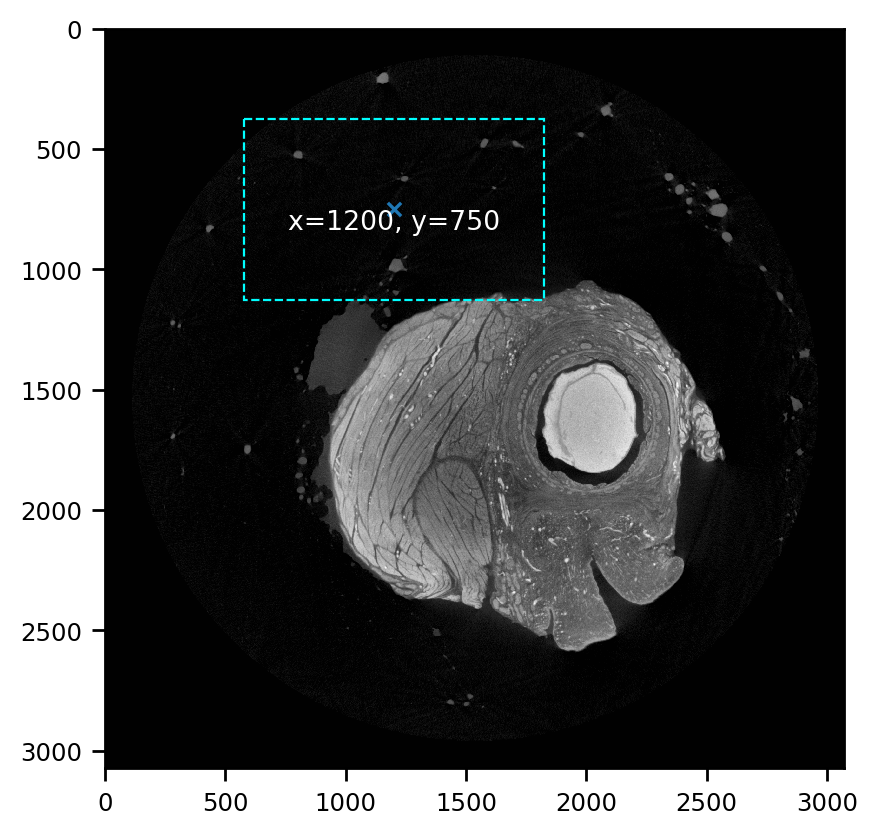

In [115]:
# Mark a ROI in an image
crop = markregion(Reconstructions[15][666],
                  (1200, 750, 1634),
                  width=1250, height=750,
                  showImage=True,
                  extract=True)

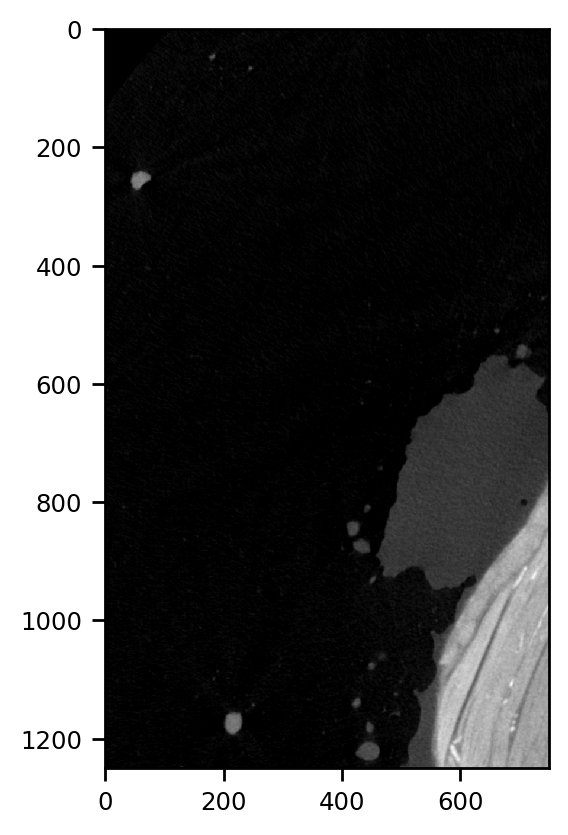

In [116]:
plt.imshow(crop)
plt.show()

In [128]:
def extract_roi(stack, coordinates, width=None, height=None, verbose=False):
    """Get a (small) region from an input stack"""
    extract=stack[coordinates[2]][coordinates[1] - int(height/2):coordinates[1] + int(height/2),
                                  coordinates[0] - int(width/2):coordinates[0]+int(width/2)]
    if verbose:
        # plt.figure(1111)
        plt.subplot(121)
        # plt.imshow(stack[coordinates[2]])
        # show region mark
        markregion(stack[coordinates[2]], coordinates, width, height, showImage=True)
        plt.title('Slice %s of input stack\n'
                  'Centered at x=%s and y=%s' % (coordinates[2], coordinates[0], coordinates[1]))
        plt.subplot(122)
        plt.imshow(extract)
        plt.title('Extract\n'
                 '%s x %s px' % (extract.shape[0], extract.shape[1]))
        plt.show()
    return(extract)

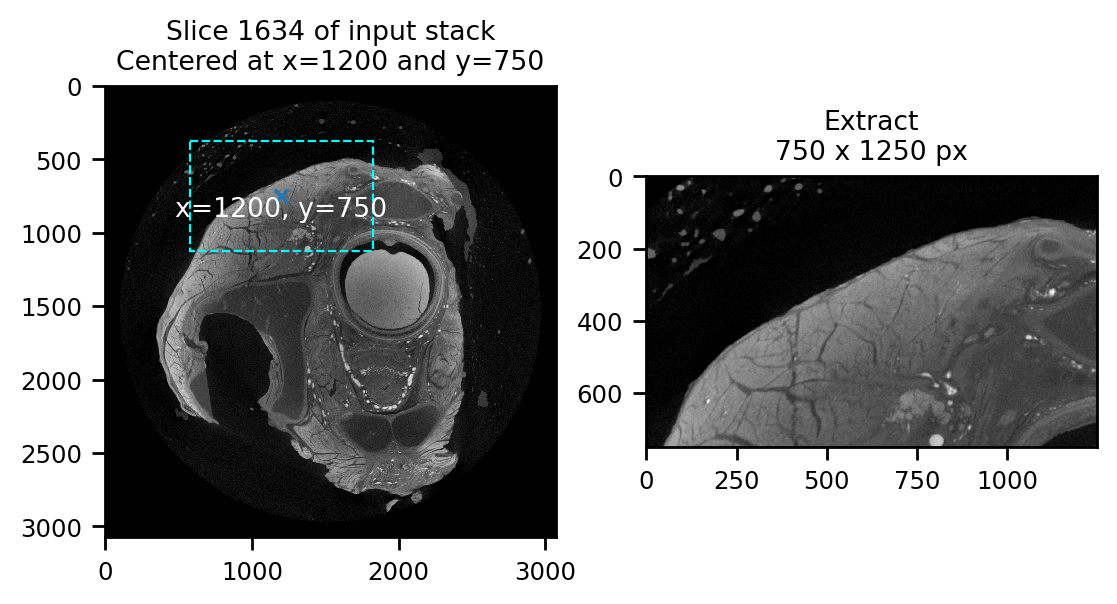

In [129]:
# Test ROI extraction
crop = extract_roi(Reconstructions[15],
                   (1200, 750, 1634),
                   width=1250, height=750,
                   verbose=True).compute()

In [130]:
def extract_roi_2d(image, coordinates, width=None, height=None, verbose=False):
    """Get a (small) region from an input image"""
    if len(coordinates) !=2:
        print('I need 2D coordinates')
        return()
    extract=image[coordinates[1] - int(height/2):coordinates[1] + int(height/2),
    coordinates[0] - int(width/2):coordinates[0]+int(width/2)]
    if verbose:
        # plt.figure(2222)
        plt.subplot(121)
        markregion(image, coordinates, width, height, showImage=True)
        plt.title('ROI centered at x=%s and y=%s' % (coordinates[0], coordinates[1]))
        plt.subplot(122)
        plt.imshow(extract)
        plt.title('Extract\n'
                 '%s x %s px' % (extract.shape[0], extract.shape[1]))
        plt.show()
    return(extract)

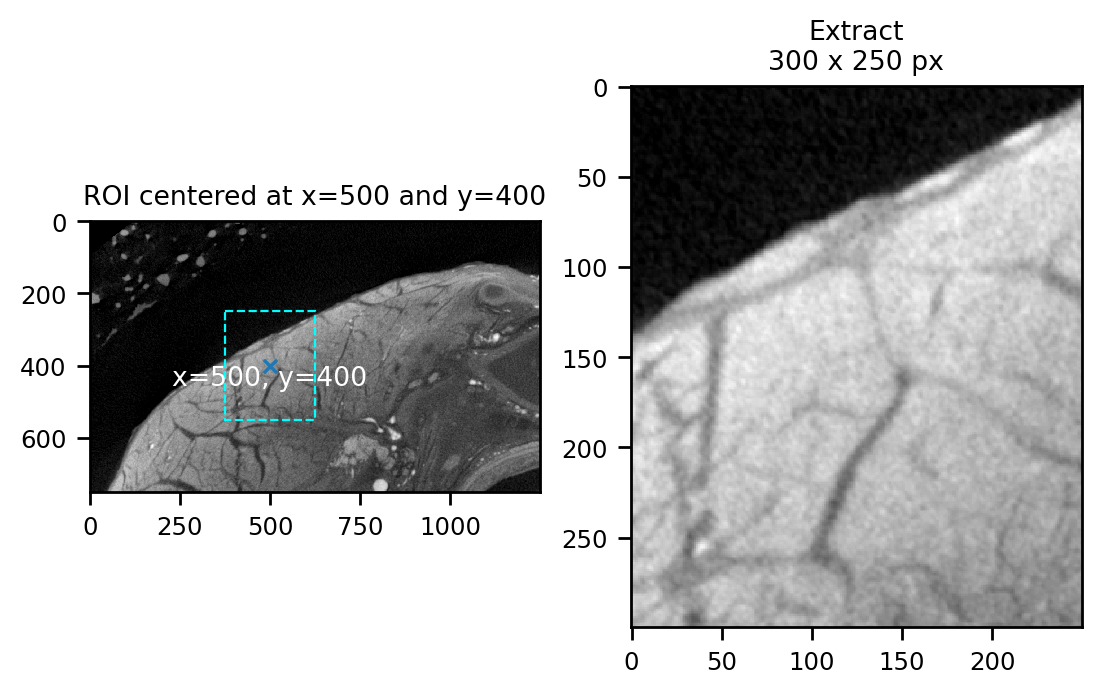

In [131]:
crop = extract_roi_2d(crop, (500, 400), width=250, height=300, verbose=True)

In [132]:
# Generate subdirectory for all figures and panels
os.makedirs('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures/', exist_ok=True)
for i in range(1, 7):
    os.makedirs(os.path.join(OutPutDir, 'Fig0%s.panels' % i), exist_ok=True)
    os.makedirs('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures/Fig0%s.panels' % i, exist_ok=True)

----
# Figure 1

We want to show a figure with the grey value curve along the timeframe we stained and scanned.
In addition some representative slices of a dataset at the start, middle and end of the duration.
And some detailed view of marked regions in these slices.

In [133]:
# Automatically find the one day closest to the middle of the duration.
# https://stackoverflow.com/a/30112305/323100
middleone = Data.index[(Data['Days passed'] - Data['Days passed'].median()).abs().argsort()[:1]][0]
Data.loc[middleone][['Sample', 'Scan', 'Days passed','Voxelsize']]

Sample         Foetus02_Lugol_15pct_070d
Scan                                 rec
Days passed             77 days 00:00:00
Voxelsize                           20.0
Name: 7, dtype: object

In [134]:
# Put ROI coordinates we want to show for this figure into dataframe
Data['Coordinates'] = ''
Data.at[0, 'Coordinates'] = [800, 900, 1634]
Data.at[middleone, 'Coordinates'] = [800, 900, 1634]
Data.at[len(Data)-1, 'Coordinates'] = [1000, 1500, 2614]

/tmp/ipykernel_1216044/257851398.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Coordinates'] = ''


In [135]:
# Recalculate voxel size scaling (for showing both 20 um and 11 um scans)
11.0/20.0

0.55

In [136]:
# Extract relevant regions from relevant images
width = 900
height = 900
detail_start = extract_roi(Reconstructions[0],
                           Data['Coordinates'][0],
                           width=width, height=height, verbose=False)
detail_mid = extract_roi(Reconstructions[middleone],
                         Data['Coordinates'][middleone],
                         width=width, height=height, verbose=False)
# Scale width/height with voxel size difference (11/20 um)
detail_end = extract_roi(Reconstructions[-1],
                         Data['Coordinates'].iloc[-1], width=width/.55, height=height/.55, verbose=False)

In [137]:
MeanBrightness_Copy = Data[Data['Grayvalue'] == 0.04]

In [138]:
plt.rcParams["figure.figsize"]

[6.4, 4.8]

In [139]:
for c, i in enumerate([0, middleone, len(Data)-2]): # Use len(Data)-*2* here, because otherwise we label at the y-value of the not-shown HR scan, which looks not so good.
    print(15 + (15 * - c))

15
0
-15


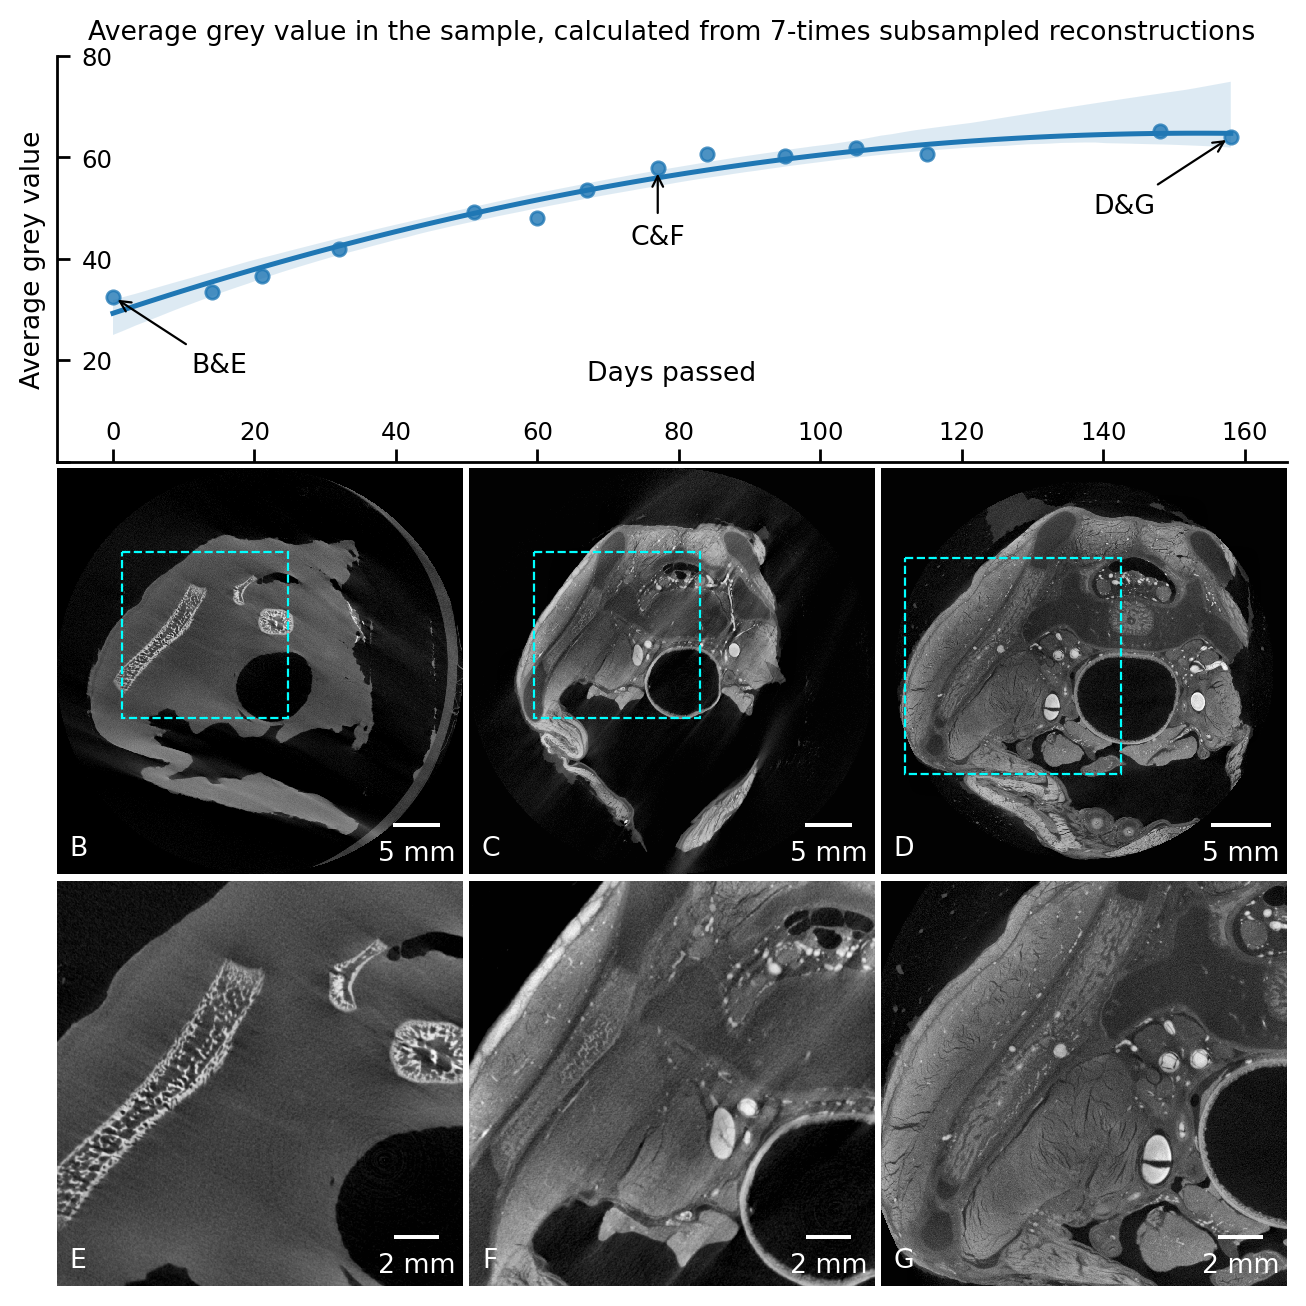

In [147]:
# Generate figure 1
fig = plt.figure(1, figsize=(plt.rcParams["figure.figsize"][0],
                             plt.rcParams["figure.figsize"][0]))
plt.subplot(3,1,1)
# Plot the mean brightness of the scan with their dates
seaborn.regplot(data=MeanBrightness_Copy,  # Only show 'low resolution scans', others should *not* be matched. We can easily do that with excluding all the ones that have not used 0.04 as max grayvalue in the reconstructions
               x='Time passed ordinal',  # Plot the grey values with 'time passed' instead of scan date
               y='MeanBrightness_masked',
               order=2)
# Mark the images we show below on the plot
for c, i in enumerate([0, middleone, len(Data)-2]): # Use len(Data)-*2* here, because otherwise we label at the y-value of the not-shown HR scan, which looks not so good.
    plt.gca().annotate('%s&%s' % (ascii_uppercase[c+1], ascii_uppercase[c+1+3]),
                       xy=(Data['Time passed ordinal'][i], Data['MeanBrightness_masked'][i]),
                       xytext=(Data['Time passed ordinal'][i] + 15 + (15 * - c), Data['MeanBrightness_masked'][i] - 15),
                       ha='center',
                       arrowprops = dict(
                           arrowstyle='->',
                           # connectionstyle='angle,angleA=0,angleB=-45,rad=5'
                       )
                       )
# Tweak the tick labels and positions to minimize plot extent
plt.gca().tick_params(axis='x', direction='in', pad=-15)
plt.xlabel('Days passed')
plt.gca().xaxis.set_label_coords(0.5, 0.25)
plt.gca().tick_params(axis='y', direction='in', pad=-20)
plt.ylim(ymin=0)
# Get ylabels to suppress the y=0 label, whichis otherwise *very* ugly
ticks = [item for item in plt.gca().get_yticks()]
labels = [item.get_text() for item in plt.gca().get_yticklabels()]
labels[0] = ''
plt.gca().set_yticks(ticks)
plt.gca().set_yticklabels(labels)
plt.ylabel('Average grey value')
if subsample != 1:
    plt.title('Average grey value from %s-times subsampled reconstructions (DO NOT USE IN FINAL VERSION!)' % subsample)
seaborn.despine()
# Add overview images
plt.subplot(3,3,4)
markregion(Reconstructions[0][Data['Coordinates'][0][2]], 
           Data['Coordinates'][0], width, height, showImage=True, showCenter=False)
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0],'um'))
label_image(Reconstructions[0][Data['Coordinates'][0][2]], 'B')
plt.axis('off')
plt.subplot(3,3,5)
markregion(Reconstructions[middleone][Data['Coordinates'][middleone][2]],
           Data['Coordinates'][middleone], width, height, showImage=True, showCenter=False)
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][middleone],'um'))
label_image(Reconstructions[middleone][Data['Coordinates'][middleone][2]], 'C')
plt.axis('off')
plt.subplot(3,3,6)
markregion(Reconstructions[-1][Data['Coordinates'].iloc[-1][2]],
           Data['Coordinates'].iloc[-1],
           width=width/.55, height=height/.55, showImage=True, showCenter=False)
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(Reconstructions[-1][Data['Coordinates'].iloc[-1][2]], 'D')
plt.axis('off')
# Add regions
plt.subplot(3,3,7)
plt.imshow(skimage.exposure.equalize_adapthist(detail_start))
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][0],'um'))
label_image(detail_start, 'E')
plt.axis('off')
plt.subplot(3,3,8)
plt.imshow(skimage.exposure.equalize_adapthist(detail_mid))
plt.gca().add_artist(ScaleBar(Data['Voxelsize'][middleone],'um'))
label_image(detail_mid, 'F')
plt.axis('off')
plt.subplot(3,3,9)
plt.imshow(skimage.exposure.equalize_adapthist(detail_end))
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(detail_end, 'G')
plt.axis('off')
plt.tight_layout(pad=0.25)
plt.savefig(os.path.join(OutPutDir, 'Fig01.png'))
plt.savefig(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures', 'Fig01.png'), facecolor='cyan')
plt.show()

----
# Figure 2

In [148]:
plt.rcParams["figure.figsize"][0] * 3 / 2.0

9.600000000000001

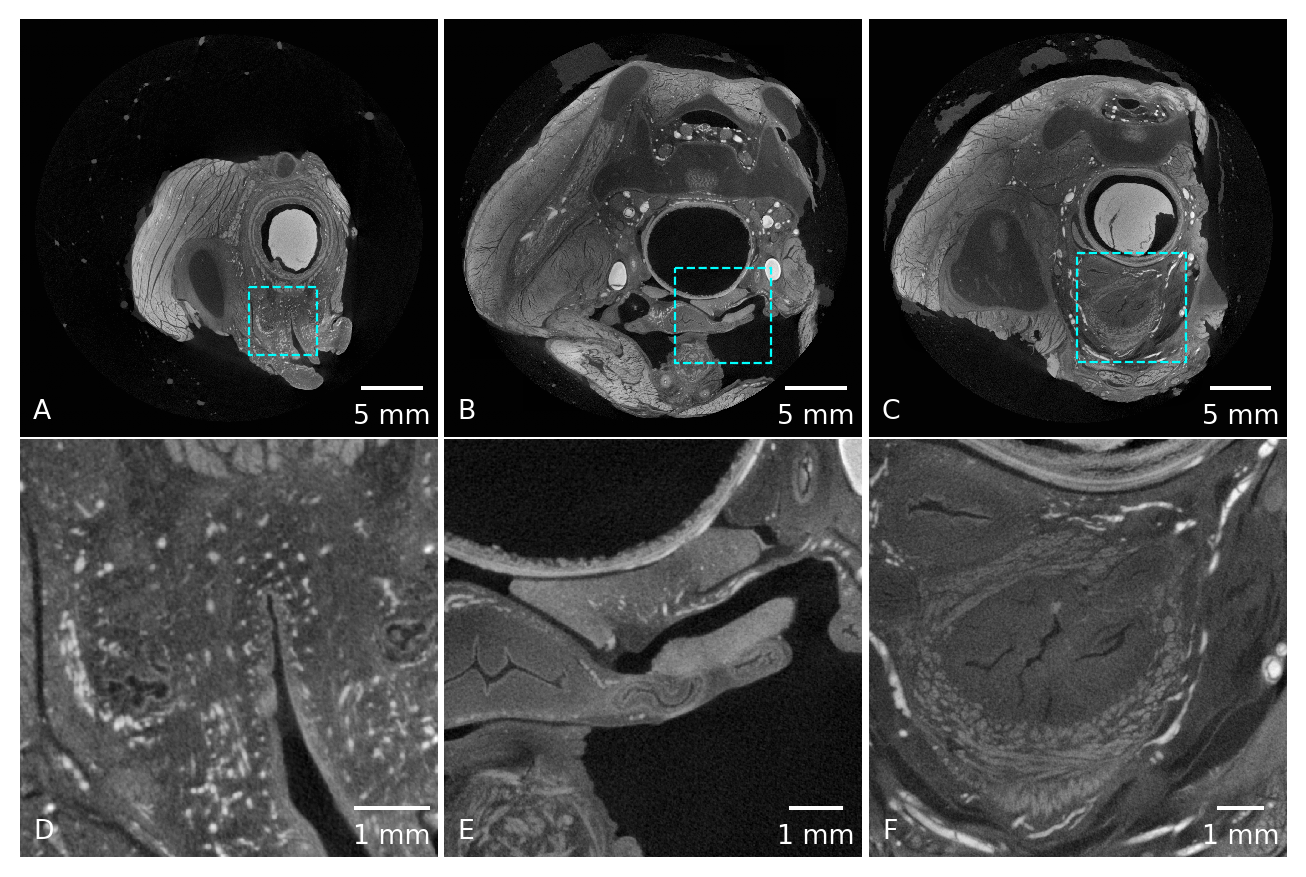

In [150]:
# Collect figure 2
fig = plt.figure(2, figsize=(plt.rcParams["figure.figsize"][0],
                             plt.rcParams["figure.figsize"][0] * 2.0 / 3.0))  # Make the figure 3:2-format
plt.subplot(231)
markregion(Reconstructions[-1][819], 
           (1936, 2218, 819), 500, 500, showImage=True, showCenter=False)
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(Reconstructions[-1][819], 'A')
plt.axis('off')
plt.subplot(232)
markregion(Reconstructions[-1][2527], 
           (2048, 2180, 2527), 700, 700, showImage=True, showCenter=False)
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(Reconstructions[-1][819], 'B')
plt.axis('off')
plt.subplot(233)
markregion(Reconstructions[-1][2044], 
           (1928, 2120, 2044), 800, 800, showImage=True, showCenter=False)
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(Reconstructions[-1][819], 'C')
plt.axis('off')
plt.subplot(234)
plt.imshow(skimage.exposure.equalize_adapthist(extract_roi(Reconstructions[-1],
                                                           (1936, 2218, 819), 500, 500)))
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(extract_roi(Reconstructions[-1],
                        (1936, 2218, 819), 500, 500),
            'D')
plt.axis('off')
plt.subplot(235)
plt.imshow(skimage.exposure.equalize_adapthist(extract_roi(Reconstructions[-1],
                                                           (2048, 2180, 2527), 700, 700)))
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(extract_roi(Reconstructions[-1],
                        (2048, 2180, 2527), 700, 700),
            'E')
plt.axis('off')
plt.subplot(236)
plt.imshow(skimage.exposure.equalize_adapthist(extract_roi(Reconstructions[-1], 
           (1928, 2120, 2044), 800, 800)))
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(extract_roi(Reconstructions[-1],
                        (1928, 2120, 2044), 800, 800),
            'F')
plt.axis('off')
plt.tight_layout(pad=0.25)
plt.savefig(os.path.join(OutPutDir, 'Fig02.png'))
plt.savefig(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures', 'Fig02.png'), facecolor='cyan')
plt.show()

----
# Figure 3

Dea marked the details/panels in a PPT, the coordinates are copy-pasted from there.

In [ ]:
a = orthoslicer(Reconstructions[-1],
                              2,
                              (2000,1600,881))
a = extract_roi_2d(a, (2000, 1600),
                   width=920, height=920, verbose=False)

In [ ]:
b = orthoslicer(Reconstructions[-1],
                              2,
                              (1990,2300,948))
b = extract_roi_2d(b, (1990, 2300),
                   width=1000, height=1000, verbose=False)
# plt.imshow(b)

In [ ]:
c = orthoslicer(Reconstructions[-1],
                              2,
                              (2000,1700,732))
c = extract_roi_2d(c, (2000, 1700),
                   width=1000, height=1000, verbose=False)
# plt.imshow(c)

In [ ]:
d = orthoslicer(Reconstructions[-1],
                              2,
                              (2040,1652,608))
d = extract_roi_2d(d, (2040, 1652),
                   width=900, height=900, verbose=False)
# plt.imshow(d)

In [ ]:
e = orthoslicer(Reconstructions[-1],
                              0,
                              (2126,3072-1900,897),
                              )
e = extract_roi_2d(e, (1900, 897),
                   width=900, height=900, verbose=False)
# plt.imshow(e)

In [ ]:
# for i in range(1890,1925,10):
    
#     f = orthoslicer(Reconstructions[-1],
#                               1,
#                               # (3072-1085,4176-3302,1114),
#                               (2100,i,1114),
#                               )
#     plt.imshow(skimage.exposure.equalize_adapthist(f[:,500:1500]))
#     plt.title(i)
#     plt.show()

In [ ]:
f = orthoslicer(Reconstructions[-1],
                              1,
                              # (3072-1085,4176-3302,1114),
                              (1112, 3072-1114, 852),
                              )
f = extract_roi_2d(f, (1980, 850),
                   width=890, height=890, verbose=False)
# plt.imshow(skimage.exposure.equalize_adapthist(f))

In [ ]:
# Save out some panels for quickly getting the coordinates to mark
imageio.imsave(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures', 'Fig03.panels', 'Fig03.A.png'),
               (255*skimage.exposure.equalize_adapthist(a.compute())).astype('uint8'))
imageio.imsave(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures', 'Fig03.panels', 'Fig03.B.png'),
               (255*skimage.exposure.equalize_adapthist(b.compute())).astype('uint8'))
imageio.imsave(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures', 'Fig03.panels', 'Fig03.C.png'),
               (255*skimage.exposure.equalize_adapthist(c.compute())).astype('uint8'))
imageio.imsave(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures', 'Fig03.panels', 'Fig03.D.png'),
               (255*skimage.exposure.equalize_adapthist(d.compute())).astype('uint8'))
imageio.imsave(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures', 'Fig03.panels', 'Fig03.E.png'),
               (255*skimage.exposure.equalize_adapthist(dask.array.flipud(e).compute())).astype('uint8'))
imageio.imsave(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures', 'Fig03.panels', 'Fig03.F.png'),
               (255*skimage.exposure.equalize_adapthist(dask.array.rot90(dask.array.rot90(f)).compute())).astype('uint8'))

In [ ]:
def ourarrow(x, y, linestyle='solid', yaw='left', pitch='up', color='cyan'):
    ''' Draws an arrow at defined position. Default arrows point to up left. '''
    horizontaldisplacement = 75
    verticaldisplacement = horizontaldisplacement
    if 'right' in yaw:
        horizontaldisplacement = horizontaldisplacement * -1
    if 'down' in pitch:
        verticaldisplacement = verticaldisplacement * -1
    plt.gca().annotate('', xy=(x, y),
                       xytext=(x + horizontaldisplacement, y + verticaldisplacement),
                       arrowprops=dict(arrowstyle = '->',
                                       linestyle=linestyle,
                                       connectionstyle = 'arc3',
                                       color=color))
    return

In [ ]:
# plt.imshow(a)
# ourarrow(400,400)
# ourarrow(400,400, yaw='right', pitch='down', color='green')
# ourarrow(400,400, yaw='left', pitch='down', color='red')
# ourarrow(400,400, yaw='right', pitch='up', color='blue')
# plt.show()

In [ ]:
fig = plt.figure(3, figsize=(plt.rcParams["figure.figsize"][0],
                             plt.rcParams["figure.figsize"][0] * 2.0 / 3.0))  # Make the figure 3:2-format
plt.subplot(2,3,1)
plt.imshow(skimage.exposure.equalize_adapthist(a))
plt.scatter(396, 807, marker='x', color='cyan')
ourarrow(452, 854)
ourarrow(486, 839)
plt.axis('off')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(a, 'A')
plt.subplot(2,3,2)
plt.imshow(skimage.exposure.equalize_adapthist(b))
plt.scatter(192, 562, marker='*', color='cyan')
plt.scatter(328, 524, marker='x', color='cyan')
plt.scatter(668, 462, marker='x', color='cyan')
ourarrow(248, 661, linestyle='dashed')
ourarrow(364, 671)
ourarrow(688, 583)
plt.axis('off')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(b, 'B')
plt.subplot(2,3,3)
plt.imshow(skimage.exposure.equalize_adapthist(c))
plt.gca().add_patch(patches.Ellipse((724, 758),
                                    150, 200, angle=10, facecolor='None', edgecolor='cyan'))
ourarrow(148, 502, yaw='right')
ourarrow(805, 662, linestyle='dashed')
ourarrow(861, 530)
plt.axis('off')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(c,'C')
plt.subplot(2,3,4)
plt.imshow(skimage.exposure.equalize_adapthist(d))
plt.axis('off')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(d,'D')
plt.subplot(2,3,5)
plt.imshow(skimage.exposure.equalize_adapthist(dask.array.flipud(e)))
ourarrow(465, 568, yaw='right')
ourarrow(460, 620, yaw='right')
ourarrow(453, 711, yaw='right')
ourarrow(519, 526, linestyle='dashed', yaw='left', pitch='down')
plt.axis('off')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(e,'E')
plt.subplot(2,3,6)
plt.imshow(skimage.exposure.equalize_adapthist(dask.array.rot90(dask.array.rot90(f))))
plt.gca().add_patch(patches.Ellipse((172, 570),
                                    150, 100, facecolor='None', edgecolor='cyan'))
ourarrow(260, 89, yaw='right', linestyle='dashed')
ourarrow(650, 806)
ourarrow(702, 33, linestyle='dashed')
ourarrow(666, 674, linestyle='dotted')
plt.scatter(408, 515, marker='*', color='cyan')
marker = MarkerStyle(marker='^')  # Thanks ChatGPT for showing me how to quickly rotate a marker :)
marker._transform.rotate_deg(45)
plt.scatter(559, 479, marker=marker, color='cyan')
plt.axis('off')
plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
label_image(f,'F')
plt.tight_layout(pad=0.25)
plt.savefig(os.path.join(OutPutDir, 'Fig03.png'))
plt.savefig(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures', 'Fig03.png'), facecolor='cyan')
plt.show()

----
# Figure 4

In [ ]:
fig = plt.figure(4, figsize=(plt.rcParams["figure.figsize"][0],
                             plt.rcParams["figure.figsize"][0] * 3.0 / 4.0))  # Make the figure 4:3-format
for c, i in enumerate(range(664,687,2)):
    # print(i)
    plt.subplot(3, 4, 11 - c + 1)
    image = orthoslicer(Reconstructions[-1],
                              2,
                              (2173, 1935, i),
                              )
    crop = extract_roi_2d(image, (2173, 1935),
            width=465, height=465, verbose=False)    
    plt.imshow(skimage.exposure.equalize_adapthist(crop))
    # write out panels, makes finding coordinates for arrows simpler :)
    imageio.imwrite(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures',
                         'Fig04.panels', 'Fig04.%04d.png' % i), (255 * skimage.exposure.equalize_adapthist(crop)).astype('uint8'))
    if c == 0:
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
    label_image(crop,i)
    plt.axis('off')
    # Markers
    plt.subplot(3, 4, 1)
    ourarrow(362, 252, yaw='right', pitch='down')
    plt.gca().add_patch(patches.Ellipse((362, 314),
                                    70, 170, angle=15, facecolor='None', edgecolor='cyan'))    
    plt.subplot(3, 4, 2)
    ourarrow(381, 248, yaw='right', pitch='down')
    ourarrow(337, 348, yaw='right', linestyle='dotted')
    plt.subplot(3, 4, 3)
    ourarrow(373, 242, yaw='right', pitch='down')
    ourarrow(322, 327, yaw='right', linestyle='dotted')
    plt.subplot(3, 4, 4)
    ourarrow(372, 242, yaw='right', pitch='down')
    ourarrow(315, 326, yaw='right', linestyle='dotted')
    plt.subplot(3, 4, 5)
    ourarrow(362, 250, yaw='right', pitch='down')
    ourarrow(315, 325, yaw='right', linestyle='dotted')
    plt.subplot(3, 4, 6)
    ourarrow(360, 240, yaw='right', pitch='down')
    ourarrow(303, 294, yaw='right', linestyle='dotted')
    plt.subplot(3, 4, 7)
    ourarrow(370, 218, yaw='right', pitch='down')
    ourarrow(297, 290, yaw='right', linestyle='dotted')
    plt.subplot(3, 4, 8)
    ourarrow(368, 227, yaw='right', pitch='down')
    ourarrow(303, 300, yaw='right', linestyle='dotted')
    plt.subplot(3, 4, 9)
    ourarrow(379, 211, yaw='right', pitch='down')
    ourarrow(295, 292, yaw='right', linestyle='dotted')
    plt.subplot(3, 4, 10)
    ourarrow(385, 199, yaw='right', pitch='down')
    ourarrow(292, 295, yaw='right', linestyle='dotted')  
    plt.subplot(3, 4, 11)
    ourarrow(381, 201, yaw='right', pitch='down')
    ourarrow(281, 283, yaw='right', linestyle='dotted')   
    plt.subplot(3, 4, 12)
    ourarrow(392, 161, yaw='right', pitch='down')
    ourarrow(256, 271, yaw='right', linestyle='dotted')
plt.tight_layout(pad=0.25)
plt.savefig(os.path.join(OutPutDir, 'Fig04.png'))
plt.savefig(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures',
                         'Fig04.png'),
            facecolor='cyan')
plt.show()

----
# Figure 5

In [ ]:
fig = plt.figure(5, figsize=(plt.rcParams["figure.figsize"][0],
                             plt.rcParams["figure.figsize"][0] * 3.0 / 4.0))  # Make the figure 4:3-format
for c, i in enumerate(range(611,656,4)):
    # print(i)
    plt.subplot(3, 4, 11 - c + 1)
    image = orthoslicer(Reconstructions[-1],
                                      2,
                                      (2000, 1935, i),
                                      )
    crop = extract_roi_2d(image, (2000, 1935),
                          width=730, height=730, verbose=False)
    plt.imshow(skimage.exposure.equalize_adapthist(crop))
    # write out panels, makes finding coordinates for arrows simpler :)
    imageio.imwrite(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures',
                         'Fig05.panels', 'Fig05.%04d.png' % i), (255 * skimage.exposure.equalize_adapthist(crop)).astype('uint8'))
    if c == 0:
        plt.gca().add_artist(ScaleBar(Data['Voxelsize'].iloc[-1],'um'))
    label_image(crop, i)
    plt.axis('off')
    # Markers
    plt.subplot(3, 4, 1)
    ourarrow(126, 484)
    marker = MarkerStyle(marker='^')  # Thanks ChatGPT for showing me how to quickly rotate a marker :)
    marker._transform.rotate_deg(45)
    plt.scatter(366, 436, marker=marker, color='cyan')
    ourarrow(679, 264, yaw='right', pitch='down', linestyle='dotted')    
    plt.subplot(3, 4, 2)
    ourarrow(139, 464)
    plt.scatter(372, 435, marker=marker, color='cyan')
    ourarrow(675, 277, yaw='right', pitch='down', linestyle='dotted')
    plt.subplot(3, 4, 3)
    ourarrow(142, 461)
    marker._transform.rotate_deg(180)
    plt.scatter(127, 366, marker=marker, color='cyan')
    ourarrow(658, 296, yaw='right', pitch='down', linestyle='dotted')
    marker._transform.rotate_deg(180)
    plt.scatter(679, 402, marker=marker, color='cyan')
    plt.subplot(3, 4, 4)
    ourarrow(107, 462)
    marker._transform.rotate_deg(180)
    plt.scatter(116, 356, marker=marker, color='cyan')
    ourarrow(661, 293, yaw='right', pitch='down', linestyle='dotted')
    marker._transform.rotate_deg(180)
    plt.scatter(671, 419, marker=marker, color='cyan')    
    plt.subplot(3, 4, 5)
    plt.scatter(105, 401, marker=marker, color='cyan')        
    ourarrow(633, 294, yaw='right', pitch='down', linestyle='dotted')
    plt.subplot(3, 4, 6)
    ourarrow(565, 339, yaw='right', pitch='down', linestyle='dotted')
    plt.subplot(3, 4, 7)
    ourarrow(587, 317, yaw='right', pitch='down', linestyle='dotted')
    ourarrow(132, 314, pitch='down', linestyle='dotted')
    plt.subplot(3, 4, 8)
    ourarrow(612, 325, yaw='right', pitch='down', linestyle='dotted')
    ourarrow(110, 302, pitch='down', linestyle='dotted')
    plt.subplot(3, 4, 9)
    ourarrow(604, 327, yaw='right', pitch='down', linestyle='dotted')
    ourarrow(66, 249, pitch='down', linestyle='dotted')
    plt.subplot(3, 4, 10)
    ourarrow(582, 325, yaw='right', pitch='down', linestyle='dotted')
    ourarrow(65, 235, pitch='down', linestyle='dotted')
    plt.subplot(3, 4, 11)
    ourarrow(617, 306, yaw='right', pitch='down', linestyle='dotted')
    ourarrow(54, 218, pitch='down', linestyle='dotted')
    plt.subplot(3, 4, 12)
    ourarrow(583, 317, yaw='right', pitch='down', linestyle='dotted')
    ourarrow(31, 134, pitch='down', linestyle='dotted')
plt.tight_layout(pad=0.25)
plt.savefig(os.path.join(OutPutDir, 'Fig05.png'))
plt.savefig(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures',
                         'Fig05.png'), facecolor='cyan')
plt.show()

----
# Figure 6

In [ ]:
cropabit = 180
a = dask_image.imread.imread(
    os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Support Material',
                 'Slicer 2 Ebenen.png'))[0,cropabit:-cropabit,cropabit:-cropabit,:]
b = dask_image.imread.imread(
    os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Support Material',
                 'Slicer 3D Model w.png'))[0,cropabit:-cropabit,cropabit:-cropabit,:]

In [ ]:
plt.rcParams["figure.figsize"]

In [ ]:
# Size figure 6 with the desired width, and just half that height, not in the standard 6.4:4.8 format
plt.figure(6, figsize=(plt.rcParams["figure.figsize"][0],
                       plt.rcParams["figure.figsize"][0]/2.0))
plt.subplot(121)
plt.imshow(a)
plt.axis('off')
label_image(a,'A', color='black')
plt.subplot(122)
plt.imshow(b)
plt.axis('off')
label_image(b,'B',color='black')
plt.tight_layout(pad=0.25)
plt.savefig(os.path.join(OutPutDir, 'Fig06.png'))
plt.savefig(os.path.join('/home/habi/research_storage_djonov/Aaldijk/PelvicFloor/Pelvis-Manuscript/Figures',
                         'Fig06.png'), facecolor='cyan')
plt.show()